#### Libraries Imported and Setup

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  NVIDIA GeForce RTX 3060 Laptop GPU


#### Model Architecture

##### Vision Transformer Model

In [3]:
class Attention(nn.Module):
    '''
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :- 
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key   = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key   = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) | Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)
        
        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [4]:
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    '''
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-
    
    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    '''
    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out 

In [5]:
class TransformerBlock(nn.Module):
    '''
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-
    
    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res
        
        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out

In [6]:
class Transformer(nn.Module):
    '''
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    '''
    def __init__(self, embed_dim, layers, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout) for i in range(layers)]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [7]:
# Not Exactly Same as Paper
class ClassificationHead(nn.Module):
    '''
    Classification Head attached to the first sequence token which is used as the arbitrary 
    classification token and used to optimize the transformer model by applying Cross-Entropy 
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    '''
    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes) 
        return out

In [8]:
class VisionTransformer(nn.Module):
    '''
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|
    
    Args:
        patch_size: Length of square patch size 
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)
    
    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    '''
    def __init__(self, patch_size, max_len, embed_dim, classes, layers, channels=3, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.name = 'VisionTransformer'
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        out = inp.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).contiguous()
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) | seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()
        
        out = out.reshape(batch_size, seq_len, -1)
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[:seq_len+1]
        position_embed = position_embed.unsqueeze(0).expand(batch_size, seq_len+1, self.embed_dim)
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim) 
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)
        
        return class_out, out

In [9]:
import torch
import torch.nn as nn
from torchvision.models import resnet34

class ResNetFeatures(nn.Module):
    '''
    ResNetFeatures outputs the lower level features from pretrained ResNet34 till the intial 5 layers 
    (conv1, bn1, relu, maxpool, layer1(3 conv layers)) to be used in the hybrid architecture to be 
    able to kickstart the learining faster. The sequence of operations is as follows :-

    Input -> conv1 -> bn1 -> relu -> maxpool -> layer1 -> Output

    Args:
        No arguments required
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, 3, 224, 224) -> (batch_size, 64, 56, 56)
    
    Examples:
        >>> resnet_features = ResNetFeatures()
        >>> out = resnet_features(inp)
    '''
    def __init__(self):
        super(ResNetFeatures, self).__init__()
        layers = list(resnet34(pretrained=True).children())[:5] #all layer expect last layer
        self.feature_extractor = nn.Sequential(*layers)
        
    def forward(self, inp):
        # inp: (batch_size, 3, 224, 224)

        out = self.feature_extractor(inp)

        # out: (batch_size, 64, 56, 56)
        return out

##### ResNet Models

In [10]:
class ResidualBlockSmall(nn.Module):
    '''
    ResidualBlockSmall implements the smaller block of the Residual Networks. It optionally also downsamples
    the input according to the stride to match the output while adding the residual. The sequence of operations
    is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Output
      |                                                              |
      |-----------------Residual_Downsample (Optional)---------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels, height, width)
    
    Examples:
        >>> RBS = ResidualBlockSmall(input_channels, out_channels, residual_downsample, stride)
        >>> out = RBS(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1):
        super(ResidualBlockSmall, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels, height, width) | height, width depending on stride
        return out

In [11]:
class ResNetSmall(nn.Module):
    '''
    ResNetSmall consists of layers of the smaller residual block defined above (ResidualBlockSmall).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetSmall(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetSmall, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=64, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=128, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=256, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        if stride != 1:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockSmall(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockSmall(output_channels, output_channels))

        return nn.Sequential(*layers)

In [12]:
class ResidualBlockLarge(nn.Module):
    '''
    ResidualBlockLarge implements the larger block of the Residual Networks. It optionally also downsamples
    the input according to the stride or output channels to match the output while adding the residual. The 
    sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Conv3 -> BNorm3 -> ReLU -> Output
      |                                                                                          |
      |-----------------------------Residual_Downsample (Optional)-------------------------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)
        expansion: Expansion of the input channels during convolutions (Default=4)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels * expansion, height, width)
    
    Examples:
        >>> RBL = ResidualBlockLarge(input_channels, out_channels, residual_downsample, stride, expansion)
        >>> out = RBL(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1, expansion=4):
        super(ResidualBlockLarge, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * expansion, kernel_size=1, stride=1, padding=0)
        self.bnorm3 = nn.BatchNorm2d(out_channels * expansion)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample
    
    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        out = self.activation(self.bnorm3(self.conv3(out)))
        
        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels * expansion, height, width) | height, width depending on stride
        return out

In [13]:
class ResNetLarge(nn.Module):
    '''
    ResNetLarge consists of layers of the larger residual block defined above (ResidualBlockLarger).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset
    
    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetLarge(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetLarge, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=256, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=512, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=1024, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        # Checks if there would be potential mismatch in any of height, width or channels between input and output. 
        # 4 is the value of the expansion for large ResNets
        if stride != 1 or input_channels != output_channels * 4:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )
        
        layers.append(ResidualBlockLarge(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockLarge(output_channels * 4, output_channels))

        return nn.Sequential(*layers)

In [14]:
def ResNet34(input_channels, classes):
    '''
    Initalization of ResNet34 using the layers as mentioned in the paper and using ResNetSmall module.

    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetSmall Object
    '''
    return ResNetSmall([3, 4, 6, 3], input_channels, classes)

In [15]:
def ResNet50(input_channels, classes):
    '''
    Initalization of ResNet50 using the layers as mentioned in the paper and using ResNetLarge module.
    
    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset
    
    Output:
        ResNetLarge Object
    '''
    return ResNetLarge([3, 4, 6, 3], input_channels, classes)

#### Data Loading Functions

In [16]:
def CIFAR100DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):
    '''
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using 
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')
    
    Output:
        DataLoader Object
    '''
    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        
        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

In [22]:
def rotate_matrix_90_degrees(matrix):
    n = len(matrix)
    for i in range(n):
        for j in range(i+1, n):
            matrix[i][j], matrix[j][i] = matrix[j][i], matrix[i][j]
    
    for i in range(n):
        for j in range(n//2):
            matrix[i][j], matrix[i][n-1-j] = matrix[i][n-1-j], matrix[i][j]

# Example of a 4x4 matrix
matrix = [
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16]
]

rotate_matrix_90_degrees(matrix)

for row in matrix:
    print(row)


[13, 9, 5, 1]
[14, 10, 6, 2]
[15, 11, 7, 3]
[16, 12, 8, 4]


#### Training and Evaluation Functions

In [17]:
# Initializations of all the constants used in the training and testing process

lr = 0.003
batch_size = 128
num_workers = 2
shuffle = True
patch_size = 4
image_sz = 32
max_len = 100
embed_dim = 512
classes = 100
layers = 12
channels = 3
heads = 16
epochs = 100


In [18]:
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    '''
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence 
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    '''
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)
        if model.name == 'VisionTransformer':
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == 'ResNet':
            output = model(data)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy

In [19]:
def evaluation(model, dataloader, criterion, resnet_features=None):
    '''
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)
    
    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    '''
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == 'VisionTransformer':
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == 'ResNet':
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy

#### Model Initialization

Run either one the following subcells according to the models selected to train and test

##### Model - Vision Transformer

Recommended Values for the following Architecture

- patch_size = 4
- max_len = 100
- embed_dim = 512
- classes = According to Dataset
- layers = 12
- channels = 3
- heads = 16

In [20]:
# Vision Transformer Architecture

model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads).to(device)

resnet_features = None

Recommended Values for the following Architecture

- patch_size = 7
- max_len = 100
- embed_dim = 512
- classes = According to Dataset
- layers = 12
- channels = 64 (Resnet Features Channels)
- heads = 16

#### Model Training and Evaluation

##### CIFAR100 Dataset

In [23]:
train_dataloader = CIFAR100DataLoader(split='train', batch_size=batch_size, num_workers=0, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR100DataLoader(split='test', batch_size=batch_size, num_workers=0, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, '\checkpoints' + model.name + '_CIFAR100_checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 391/391 [02:18<00:00,  2.82it/s]


Epoch : 1 - acc: 0.2131 - loss : 3.2270



100%|██████████| 79/79 [00:09<00:00,  7.91it/s]


test acc: 0.2318 - test loss : 3.1710



100%|██████████| 391/391 [02:41<00:00,  2.42it/s]


Epoch : 2 - acc: 0.2271 - loss : 3.1398



100%|██████████| 79/79 [00:11<00:00,  7.11it/s]


test acc: 0.2414 - test loss : 3.0970



100%|██████████| 391/391 [02:43<00:00,  2.39it/s]


Epoch : 3 - acc: 0.2411 - loss : 3.0730



100%|██████████| 79/79 [00:10<00:00,  7.42it/s]


test acc: 0.2604 - test loss : 3.0034



100%|██████████| 391/391 [02:43<00:00,  2.39it/s]


Epoch : 4 - acc: 0.2533 - loss : 3.0082



100%|██████████| 79/79 [00:10<00:00,  7.56it/s]


test acc: 0.2584 - test loss : 2.9844



100%|██████████| 391/391 [02:43<00:00,  2.39it/s]


Epoch : 5 - acc: 0.2642 - loss : 2.9536



100%|██████████| 79/79 [00:10<00:00,  7.51it/s]


test acc: 0.2723 - test loss : 2.9512



100%|██████████| 391/391 [02:46<00:00,  2.35it/s]


Epoch : 6 - acc: 0.2714 - loss : 2.9049



100%|██████████| 79/79 [00:11<00:00,  6.74it/s]


test acc: 0.2827 - test loss : 2.8896



100%|██████████| 391/391 [02:50<00:00,  2.30it/s]


Epoch : 7 - acc: 0.2803 - loss : 2.8524



100%|██████████| 79/79 [00:11<00:00,  6.71it/s]


test acc: 0.2854 - test loss : 2.8497



100%|██████████| 391/391 [02:49<00:00,  2.31it/s]


Epoch : 8 - acc: 0.2897 - loss : 2.8180



100%|██████████| 79/79 [00:11<00:00,  6.77it/s]


test acc: 0.2933 - test loss : 2.8447



100%|██████████| 391/391 [02:49<00:00,  2.30it/s]


Epoch : 9 - acc: 0.3018 - loss : 2.7633



100%|██████████| 79/79 [00:11<00:00,  6.80it/s]


test acc: 0.2959 - test loss : 2.8088



100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch : 10 - acc: 0.3059 - loss : 2.7274



100%|██████████| 79/79 [00:11<00:00,  6.78it/s]


test acc: 0.3048 - test loss : 2.7780



100%|██████████| 391/391 [02:48<00:00,  2.32it/s]


Epoch : 11 - acc: 0.3152 - loss : 2.6848



100%|██████████| 79/79 [00:11<00:00,  6.71it/s]


test acc: 0.3033 - test loss : 2.7717



100%|██████████| 391/391 [02:49<00:00,  2.30it/s]


Epoch : 12 - acc: 0.3230 - loss : 2.6530



100%|██████████| 79/79 [00:11<00:00,  6.76it/s]


test acc: 0.3121 - test loss : 2.7495



100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch : 13 - acc: 0.3284 - loss : 2.6159



100%|██████████| 79/79 [00:11<00:00,  7.14it/s]


test acc: 0.3200 - test loss : 2.7206



100%|██████████| 391/391 [02:47<00:00,  2.33it/s]


Epoch : 14 - acc: 0.3379 - loss : 2.5760



100%|██████████| 79/79 [00:11<00:00,  6.92it/s]


test acc: 0.3245 - test loss : 2.6945



100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch : 15 - acc: 0.3419 - loss : 2.5495



100%|██████████| 79/79 [00:12<00:00,  6.08it/s]


test acc: 0.3330 - test loss : 2.6919



100%|██████████| 391/391 [02:51<00:00,  2.29it/s]


Epoch : 16 - acc: 0.3483 - loss : 2.5283



100%|██████████| 79/79 [00:11<00:00,  6.66it/s]


test acc: 0.3270 - test loss : 2.6958



100%|██████████| 391/391 [02:45<00:00,  2.37it/s]


Epoch : 17 - acc: 0.3577 - loss : 2.4842



100%|██████████| 79/79 [00:11<00:00,  6.81it/s]


test acc: 0.3380 - test loss : 2.6422



100%|██████████| 391/391 [02:47<00:00,  2.33it/s]


Epoch : 18 - acc: 0.3600 - loss : 2.4558



100%|██████████| 79/79 [00:10<00:00,  7.39it/s]


test acc: 0.3387 - test loss : 2.6522



100%|██████████| 391/391 [02:46<00:00,  2.34it/s]


Epoch : 19 - acc: 0.3714 - loss : 2.4154



100%|██████████| 79/79 [00:11<00:00,  6.98it/s]


test acc: 0.3420 - test loss : 2.6318



100%|██████████| 391/391 [02:48<00:00,  2.32it/s]


Epoch : 20 - acc: 0.3749 - loss : 2.3894



100%|██████████| 79/79 [00:11<00:00,  7.02it/s]


test acc: 0.3373 - test loss : 2.6352



100%|██████████| 391/391 [02:48<00:00,  2.32it/s]


Epoch : 21 - acc: 0.3796 - loss : 2.3644



100%|██████████| 79/79 [00:11<00:00,  6.78it/s]


test acc: 0.3408 - test loss : 2.6596



100%|██████████| 391/391 [02:46<00:00,  2.35it/s]


Epoch : 22 - acc: 0.3842 - loss : 2.3505



100%|██████████| 79/79 [00:11<00:00,  7.00it/s]


test acc: 0.3467 - test loss : 2.6279



100%|██████████| 391/391 [02:47<00:00,  2.34it/s]


Epoch : 23 - acc: 0.3939 - loss : 2.3084



100%|██████████| 79/79 [00:11<00:00,  7.16it/s]


test acc: 0.3511 - test loss : 2.6099



100%|██████████| 391/391 [02:45<00:00,  2.36it/s]


Epoch : 24 - acc: 0.3977 - loss : 2.2872



100%|██████████| 79/79 [00:11<00:00,  7.15it/s]


test acc: 0.3552 - test loss : 2.6003



100%|██████████| 391/391 [02:44<00:00,  2.37it/s]


Epoch : 25 - acc: 0.4041 - loss : 2.2515



100%|██████████| 79/79 [00:11<00:00,  6.95it/s]


test acc: 0.3568 - test loss : 2.5883



100%|██████████| 391/391 [02:45<00:00,  2.36it/s]


Epoch : 26 - acc: 0.4079 - loss : 2.2284



100%|██████████| 79/79 [00:11<00:00,  7.10it/s]


test acc: 0.3505 - test loss : 2.5882



100%|██████████| 391/391 [02:45<00:00,  2.37it/s]


Epoch : 27 - acc: 0.4142 - loss : 2.2094



100%|██████████| 79/79 [00:11<00:00,  7.13it/s]


test acc: 0.3611 - test loss : 2.5646



100%|██████████| 391/391 [02:45<00:00,  2.36it/s]


Epoch : 28 - acc: 0.4191 - loss : 2.1756



100%|██████████| 79/79 [00:11<00:00,  7.17it/s]


test acc: 0.3624 - test loss : 2.5829



100%|██████████| 391/391 [02:44<00:00,  2.38it/s]


Epoch : 29 - acc: 0.4268 - loss : 2.1507



100%|██████████| 79/79 [00:11<00:00,  7.14it/s]


test acc: 0.3598 - test loss : 2.5746



100%|██████████| 391/391 [02:44<00:00,  2.37it/s]


Epoch : 30 - acc: 0.4307 - loss : 2.1249



100%|██████████| 79/79 [00:11<00:00,  7.07it/s]


test acc: 0.3648 - test loss : 2.5942



100%|██████████| 391/391 [02:43<00:00,  2.39it/s]


Epoch : 31 - acc: 0.4386 - loss : 2.0989



100%|██████████| 79/79 [00:10<00:00,  7.26it/s]


test acc: 0.3651 - test loss : 2.5681



100%|██████████| 391/391 [02:46<00:00,  2.35it/s]


Epoch : 32 - acc: 0.4444 - loss : 2.0637



100%|██████████| 79/79 [00:11<00:00,  7.14it/s]


test acc: 0.3741 - test loss : 2.5623



100%|██████████| 391/391 [02:45<00:00,  2.36it/s]


Epoch : 33 - acc: 0.4496 - loss : 2.0370



100%|██████████| 79/79 [00:11<00:00,  7.07it/s]


test acc: 0.3708 - test loss : 2.5799



100%|██████████| 391/391 [02:45<00:00,  2.36it/s]


Epoch : 34 - acc: 0.4583 - loss : 2.0176



100%|██████████| 79/79 [00:11<00:00,  7.05it/s]


test acc: 0.3684 - test loss : 2.5612



100%|██████████| 391/391 [02:43<00:00,  2.38it/s]


Epoch : 35 - acc: 0.4595 - loss : 1.9987



100%|██████████| 79/79 [00:10<00:00,  7.35it/s]


test acc: 0.3741 - test loss : 2.5481



100%|██████████| 391/391 [02:37<00:00,  2.48it/s]


Epoch : 36 - acc: 0.4630 - loss : 1.9772



100%|██████████| 79/79 [00:10<00:00,  7.81it/s]


test acc: 0.3769 - test loss : 2.5564



100%|██████████| 391/391 [02:45<00:00,  2.36it/s]


Epoch : 37 - acc: 0.4723 - loss : 1.9497



100%|██████████| 79/79 [00:11<00:00,  7.10it/s]


test acc: 0.3743 - test loss : 2.5633



100%|██████████| 391/391 [02:49<00:00,  2.30it/s]


Epoch : 38 - acc: 0.4724 - loss : 1.9318



100%|██████████| 79/79 [00:11<00:00,  7.01it/s]


test acc: 0.3743 - test loss : 2.5700



100%|██████████| 391/391 [02:39<00:00,  2.45it/s]


Epoch : 39 - acc: 0.4813 - loss : 1.9040



100%|██████████| 79/79 [00:10<00:00,  7.86it/s]


test acc: 0.3682 - test loss : 2.6032



100%|██████████| 391/391 [02:36<00:00,  2.50it/s]


Epoch : 40 - acc: 0.4840 - loss : 1.8803



100%|██████████| 79/79 [00:10<00:00,  7.88it/s]


test acc: 0.3732 - test loss : 2.5775



100%|██████████| 391/391 [02:35<00:00,  2.51it/s]


Epoch : 41 - acc: 0.4891 - loss : 1.8557



100%|██████████| 79/79 [00:09<00:00,  8.20it/s]


test acc: 0.3705 - test loss : 2.5954



100%|██████████| 391/391 [02:35<00:00,  2.51it/s]


Epoch : 42 - acc: 0.4925 - loss : 1.8370



100%|██████████| 79/79 [00:09<00:00,  7.94it/s]


test acc: 0.3796 - test loss : 2.5669



100%|██████████| 391/391 [02:32<00:00,  2.56it/s]


Epoch : 43 - acc: 0.4976 - loss : 1.8183



100%|██████████| 79/79 [00:10<00:00,  7.85it/s]


test acc: 0.3774 - test loss : 2.5837



100%|██████████| 391/391 [02:34<00:00,  2.53it/s]


Epoch : 44 - acc: 0.5067 - loss : 1.7890



100%|██████████| 79/79 [00:10<00:00,  7.82it/s]


test acc: 0.3806 - test loss : 2.5784



100%|██████████| 391/391 [02:33<00:00,  2.55it/s]


Epoch : 45 - acc: 0.5129 - loss : 1.7616



100%|██████████| 79/79 [00:09<00:00,  8.22it/s]


test acc: 0.3889 - test loss : 2.5696



100%|██████████| 391/391 [02:33<00:00,  2.55it/s]


Epoch : 46 - acc: 0.5144 - loss : 1.7417



100%|██████████| 79/79 [00:09<00:00,  7.99it/s]


test acc: 0.3804 - test loss : 2.6088



100%|██████████| 391/391 [02:34<00:00,  2.54it/s]


Epoch : 47 - acc: 0.5235 - loss : 1.7125



100%|██████████| 79/79 [00:10<00:00,  7.78it/s]


test acc: 0.3860 - test loss : 2.6285



100%|██████████| 391/391 [02:34<00:00,  2.53it/s]


Epoch : 48 - acc: 0.5249 - loss : 1.6992



100%|██████████| 79/79 [00:09<00:00,  7.98it/s]


test acc: 0.3793 - test loss : 2.5925



100%|██████████| 391/391 [02:34<00:00,  2.53it/s]


Epoch : 49 - acc: 0.5278 - loss : 1.6744



100%|██████████| 79/79 [00:09<00:00,  7.93it/s]


test acc: 0.3772 - test loss : 2.6513



100%|██████████| 391/391 [02:33<00:00,  2.54it/s]


Epoch : 50 - acc: 0.5353 - loss : 1.6464



100%|██████████| 79/79 [00:09<00:00,  7.99it/s]


test acc: 0.3863 - test loss : 2.6188



100%|██████████| 391/391 [02:33<00:00,  2.54it/s]


Epoch : 51 - acc: 0.5420 - loss : 1.6253



100%|██████████| 79/79 [00:10<00:00,  7.67it/s]


test acc: 0.3868 - test loss : 2.6394



100%|██████████| 391/391 [02:33<00:00,  2.54it/s]


Epoch : 52 - acc: 0.5446 - loss : 1.6179



100%|██████████| 79/79 [00:10<00:00,  7.81it/s]


test acc: 0.3811 - test loss : 2.6457



100%|██████████| 391/391 [02:33<00:00,  2.55it/s]


Epoch : 53 - acc: 0.5539 - loss : 1.5846



100%|██████████| 79/79 [00:10<00:00,  7.81it/s]


test acc: 0.3866 - test loss : 2.6543



100%|██████████| 391/391 [02:33<00:00,  2.55it/s]


Epoch : 54 - acc: 0.5588 - loss : 1.5590



100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


test acc: 0.3853 - test loss : 2.6757



100%|██████████| 391/391 [02:33<00:00,  2.55it/s]


Epoch : 55 - acc: 0.5653 - loss : 1.5321



100%|██████████| 79/79 [00:09<00:00,  8.12it/s]


test acc: 0.3935 - test loss : 2.6435



100%|██████████| 391/391 [02:33<00:00,  2.56it/s]


Epoch : 56 - acc: 0.5696 - loss : 1.5108



100%|██████████| 79/79 [00:10<00:00,  7.41it/s]


test acc: 0.3862 - test loss : 2.6776



100%|██████████| 391/391 [02:33<00:00,  2.55it/s]


Epoch : 57 - acc: 0.5707 - loss : 1.5032



100%|██████████| 79/79 [00:09<00:00,  8.21it/s]


test acc: 0.3819 - test loss : 2.7138



100%|██████████| 391/391 [02:33<00:00,  2.55it/s]


Epoch : 58 - acc: 0.5776 - loss : 1.4719



100%|██████████| 79/79 [00:09<00:00,  8.08it/s]


test acc: 0.3846 - test loss : 2.6729



100%|██████████| 391/391 [02:34<00:00,  2.54it/s]


Epoch : 59 - acc: 0.5831 - loss : 1.4538



100%|██████████| 79/79 [00:10<00:00,  7.54it/s]


test acc: 0.3788 - test loss : 2.7189



100%|██████████| 391/391 [02:34<00:00,  2.54it/s]


Epoch : 60 - acc: 0.5852 - loss : 1.4378



100%|██████████| 79/79 [00:09<00:00,  7.93it/s]


test acc: 0.3871 - test loss : 2.7390



100%|██████████| 391/391 [02:32<00:00,  2.56it/s]


Epoch : 61 - acc: 0.5966 - loss : 1.4079



100%|██████████| 79/79 [00:10<00:00,  7.85it/s]


test acc: 0.3870 - test loss : 2.7028



100%|██████████| 391/391 [02:32<00:00,  2.56it/s]


Epoch : 62 - acc: 0.5982 - loss : 1.3998



100%|██████████| 79/79 [00:10<00:00,  7.88it/s]


test acc: 0.3859 - test loss : 2.7302



100%|██████████| 391/391 [02:33<00:00,  2.55it/s]


Epoch : 63 - acc: 0.6022 - loss : 1.3731



100%|██████████| 79/79 [00:10<00:00,  7.83it/s]


test acc: 0.3863 - test loss : 2.7762



100%|██████████| 391/391 [02:33<00:00,  2.55it/s]


Epoch : 64 - acc: 0.6059 - loss : 1.3599



100%|██████████| 79/79 [00:09<00:00,  8.00it/s]


test acc: 0.3897 - test loss : 2.7286



100%|██████████| 391/391 [02:33<00:00,  2.55it/s]


Epoch : 65 - acc: 0.6130 - loss : 1.3275



100%|██████████| 79/79 [00:09<00:00,  7.97it/s]


test acc: 0.3915 - test loss : 2.7505



100%|██████████| 391/391 [02:33<00:00,  2.55it/s]


Epoch : 66 - acc: 0.6181 - loss : 1.3158



100%|██████████| 79/79 [00:09<00:00,  8.07it/s]


test acc: 0.3894 - test loss : 2.7689



100%|██████████| 391/391 [02:33<00:00,  2.55it/s]


Epoch : 67 - acc: 0.6210 - loss : 1.3012



100%|██████████| 79/79 [00:10<00:00,  7.87it/s]


test acc: 0.3871 - test loss : 2.7660



100%|██████████| 391/391 [02:32<00:00,  2.57it/s]


Epoch : 68 - acc: 0.6237 - loss : 1.2867



100%|██████████| 79/79 [00:09<00:00,  7.91it/s]


test acc: 0.3853 - test loss : 2.8016



100%|██████████| 391/391 [02:32<00:00,  2.56it/s]


Epoch : 69 - acc: 0.6289 - loss : 1.2642



100%|██████████| 79/79 [00:09<00:00,  8.15it/s]


test acc: 0.3803 - test loss : 2.8593



100%|██████████| 391/391 [02:32<00:00,  2.56it/s]


Epoch : 70 - acc: 0.6341 - loss : 1.2429



100%|██████████| 79/79 [00:10<00:00,  7.26it/s]


test acc: 0.3856 - test loss : 2.8348



100%|██████████| 391/391 [02:34<00:00,  2.53it/s]


Epoch : 71 - acc: 0.6415 - loss : 1.2122



100%|██████████| 79/79 [00:09<00:00,  8.11it/s]


test acc: 0.3921 - test loss : 2.8587



100%|██████████| 391/391 [02:32<00:00,  2.56it/s]


Epoch : 72 - acc: 0.6440 - loss : 1.2016



100%|██████████| 79/79 [00:09<00:00,  7.94it/s]


test acc: 0.3897 - test loss : 2.8758



100%|██████████| 391/391 [02:32<00:00,  2.57it/s]


Epoch : 73 - acc: 0.6526 - loss : 1.1749



100%|██████████| 79/79 [00:10<00:00,  7.68it/s]


test acc: 0.3904 - test loss : 2.8895



100%|██████████| 391/391 [02:33<00:00,  2.54it/s]


Epoch : 74 - acc: 0.6559 - loss : 1.1580



100%|██████████| 79/79 [00:09<00:00,  7.97it/s]


test acc: 0.3844 - test loss : 2.9094



100%|██████████| 391/391 [02:33<00:00,  2.55it/s]


Epoch : 75 - acc: 0.6587 - loss : 1.1495



100%|██████████| 79/79 [00:09<00:00,  7.94it/s]


test acc: 0.3915 - test loss : 2.8479



100%|██████████| 391/391 [02:32<00:00,  2.57it/s]


Epoch : 76 - acc: 0.6643 - loss : 1.1225



100%|██████████| 79/79 [00:09<00:00,  8.10it/s]


test acc: 0.3924 - test loss : 2.9127



100%|██████████| 391/391 [02:32<00:00,  2.57it/s]


Epoch : 77 - acc: 0.6706 - loss : 1.0995



100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


test acc: 0.3942 - test loss : 2.9455



100%|██████████| 391/391 [02:32<00:00,  2.57it/s]


Epoch : 78 - acc: 0.6747 - loss : 1.0847



100%|██████████| 79/79 [00:10<00:00,  7.74it/s]


test acc: 0.3934 - test loss : 2.9719



100%|██████████| 391/391 [02:32<00:00,  2.57it/s]


Epoch : 79 - acc: 0.6789 - loss : 1.0673



100%|██████████| 79/79 [00:09<00:00,  8.06it/s]


test acc: 0.3894 - test loss : 2.9787



100%|██████████| 391/391 [02:31<00:00,  2.57it/s]


Epoch : 80 - acc: 0.6851 - loss : 1.0475



100%|██████████| 79/79 [00:09<00:00,  8.03it/s]


test acc: 0.3827 - test loss : 3.0438



100%|██████████| 391/391 [02:33<00:00,  2.55it/s]


Epoch : 81 - acc: 0.6870 - loss : 1.0457



100%|██████████| 79/79 [00:10<00:00,  7.77it/s]


test acc: 0.3945 - test loss : 3.0177



100%|██████████| 391/391 [02:34<00:00,  2.52it/s]


Epoch : 82 - acc: 0.6902 - loss : 1.0227



100%|██████████| 79/79 [00:11<00:00,  6.84it/s]


test acc: 0.3886 - test loss : 2.9949



100%|██████████| 391/391 [02:42<00:00,  2.40it/s]


Epoch : 83 - acc: 0.6959 - loss : 1.0031



100%|██████████| 79/79 [00:11<00:00,  6.72it/s]


test acc: 0.3922 - test loss : 3.0403



100%|██████████| 391/391 [02:52<00:00,  2.26it/s]


Epoch : 84 - acc: 0.7027 - loss : 0.9814



100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


test acc: 0.3976 - test loss : 3.0326



100%|██████████| 391/391 [02:59<00:00,  2.18it/s]


Epoch : 85 - acc: 0.7066 - loss : 0.9636



100%|██████████| 79/79 [00:11<00:00,  7.10it/s]


test acc: 0.3932 - test loss : 3.0579



100%|██████████| 391/391 [02:43<00:00,  2.39it/s]


Epoch : 86 - acc: 0.7057 - loss : 0.9668



100%|██████████| 79/79 [00:12<00:00,  6.50it/s]


test acc: 0.3879 - test loss : 3.1005



100%|██████████| 391/391 [02:42<00:00,  2.41it/s]


Epoch : 87 - acc: 0.7123 - loss : 0.9403



100%|██████████| 79/79 [00:11<00:00,  7.07it/s]


test acc: 0.3918 - test loss : 3.0998



100%|██████████| 391/391 [02:41<00:00,  2.42it/s]


Epoch : 88 - acc: 0.7180 - loss : 0.9190



100%|██████████| 79/79 [00:11<00:00,  7.00it/s]


test acc: 0.3900 - test loss : 3.0755



100%|██████████| 391/391 [02:42<00:00,  2.41it/s]


Epoch : 89 - acc: 0.7238 - loss : 0.8986



100%|██████████| 79/79 [00:11<00:00,  6.84it/s]


test acc: 0.3953 - test loss : 3.0910



100%|██████████| 391/391 [02:41<00:00,  2.43it/s]


Epoch : 90 - acc: 0.7254 - loss : 0.8930



100%|██████████| 79/79 [00:11<00:00,  6.95it/s]


test acc: 0.3915 - test loss : 3.1280



100%|██████████| 391/391 [02:45<00:00,  2.36it/s]


Epoch : 91 - acc: 0.7282 - loss : 0.8823



100%|██████████| 79/79 [00:11<00:00,  6.67it/s]


test acc: 0.3899 - test loss : 3.1238



100%|██████████| 391/391 [02:49<00:00,  2.31it/s]


Epoch : 92 - acc: 0.7316 - loss : 0.8679



100%|██████████| 79/79 [00:11<00:00,  6.67it/s]


test acc: 0.3884 - test loss : 3.1656



100%|██████████| 391/391 [02:50<00:00,  2.29it/s]


Epoch : 93 - acc: 0.7395 - loss : 0.8455



100%|██████████| 79/79 [00:11<00:00,  6.65it/s]


test acc: 0.3879 - test loss : 3.2112



100%|██████████| 391/391 [02:51<00:00,  2.28it/s]


Epoch : 94 - acc: 0.7392 - loss : 0.8416



100%|██████████| 79/79 [00:11<00:00,  6.93it/s]


test acc: 0.3894 - test loss : 3.2359



100%|██████████| 391/391 [02:44<00:00,  2.38it/s]


Epoch : 95 - acc: 0.7448 - loss : 0.8224



100%|██████████| 79/79 [00:10<00:00,  7.69it/s]


test acc: 0.3904 - test loss : 3.1810



100%|██████████| 391/391 [02:41<00:00,  2.41it/s]


Epoch : 96 - acc: 0.7486 - loss : 0.8144



100%|██████████| 79/79 [00:10<00:00,  7.66it/s]


test acc: 0.3919 - test loss : 3.2733



100%|██████████| 391/391 [02:38<00:00,  2.47it/s]


Epoch : 97 - acc: 0.7535 - loss : 0.7942



100%|██████████| 79/79 [00:10<00:00,  7.85it/s]


test acc: 0.3921 - test loss : 3.2918



100%|██████████| 391/391 [02:47<00:00,  2.34it/s]


Epoch : 98 - acc: 0.7551 - loss : 0.7813



100%|██████████| 79/79 [00:11<00:00,  7.16it/s]


test acc: 0.3919 - test loss : 3.2632



100%|██████████| 391/391 [02:42<00:00,  2.40it/s]


Epoch : 99 - acc: 0.7626 - loss : 0.7714



100%|██████████| 79/79 [00:11<00:00,  7.15it/s]


test acc: 0.3860 - test loss : 3.3064



100%|██████████| 391/391 [02:46<00:00,  2.35it/s]


Epoch : 100 - acc: 0.7613 - loss : 0.7609



100%|██████████| 79/79 [00:11<00:00,  6.69it/s]

test acc: 0.3968 - test loss : 3.2665



##### Plotting Results

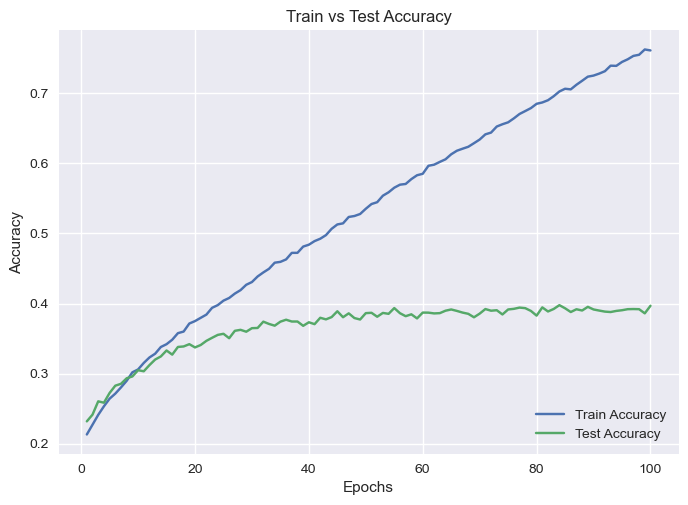

In [24]:
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 101), train_accs, label='Train Accuracy')
plt.plot(range(1, 101), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')